In [13]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml
import kerastuner as kt

# Load the Boston Housing dataset
boston = fetch_openml(name='boston', version=1)
data, target = boston.data, boston.target

# Test & Train Split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Scaling test and train set
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model-building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(layers.Dense(units=hp.Int('dense_units1', min_value=32, max_value=256, step=32), activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(layers.Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.6, step=0.1)))
    model.add(layers.Dense(units=hp.Int('dense_units2', min_value=16, max_value=128, step=16), activation='relu'))
    model.add(layers.Dense(1))

    model.compile(
        loss='mse',
        optimizer=RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        metrics=['mae']
    )

    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='tuner_results',
    project_name='boston_housing_tuning'
)

# Perform hyperparameter tuning
tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.1, verbose=2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best Hyperparameters: {best_hps}")

# Build the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train the final model
final_model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.1, verbose=2)

# Evaluate the final model on the test set
test_loss, test_mae = final_model.evaluate(X_test_scaled, y_test)
print('Mean Squared Error on Test Set:', test_loss)
print('Mean Absolute Error on Test Set:', test_mae)


Trial 90 Complete [00h 00m 08s]
val_loss: 25.032726287841797

Best val_loss So Far: 19.3942813873291
Total elapsed time: 00h 04m 18s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001DCF8D8EF50>
Epoch 1/50
12/12 - 1s - loss: 196.1760 - mae: 10.5276 - val_loss: 51.3109 - val_mae: 4.9629 - 765ms/epoch - 64ms/step
Epoch 2/50
12/12 - 0s - loss: 67.0561 - mae: 5.9580 - val_loss: 105.7807 - val_mae: 8.0654 - 65ms/epoch - 5ms/step
Epoch 3/50
12/12 - 0s - loss: 56.3148 - mae: 5.4469 - val_loss: 42.2375 - val_mae: 4.8803 - 68ms/epoch - 6ms/step
Epoch 4/50
12/12 - 0s - loss: 52.3680 - mae: 5.4324 - val_loss: 69.6756 - val_mae: 6.1171 - 68ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 50.4994 - mae: 5.2919 - val_loss: 47.8204 - val_mae: 4.5256 - 68ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 37.4641 - mae: 4.4935 - val_loss: 45.0700 - val_mae: 5.3461 - 71ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 42.4541 - mae: 4.9867 - 

4/4 [==============================] - 4s 54ms/step


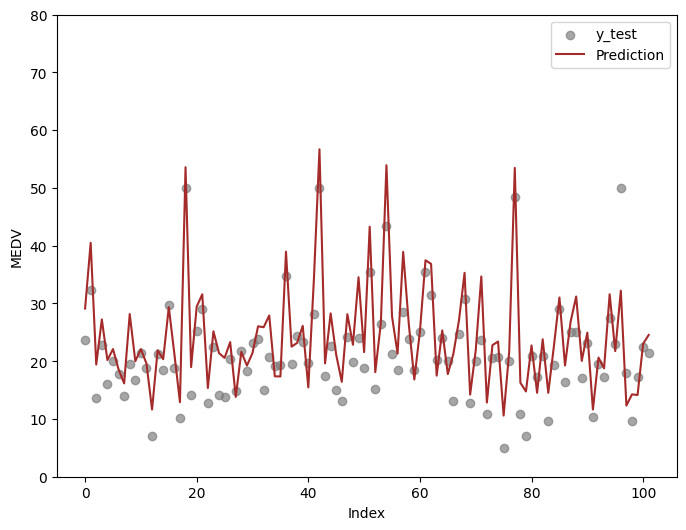

In [14]:
pred=final_model.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test_array)), y_test_array, color='grey', label='y_test', alpha=0.7)

# Plot pred in brown
plt.plot(pred, color='brown', label='Prediction')

# Set y-axis limits
plt.ylim(0, 80)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('MEDV')
plt.legend()

# Show the plot
plt.show()